In [1]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data from Arctic database

In [5]:
list_of_markets=get_market_list()
df=pd.DataFrame()
for m in list_of_markets:
    try:
        df[m]=get_timeseries(m)
    except:
        print m

In [7]:
mkts=list_of_markets
pos=tsmom_daily(df[mkts],250)
pnl=calc_pnl_wc(pos,df[mkts])
scaling_factor=calc_scaling_factor(pnl)
portfolio= remove_inf(pnl).mean(axis=1).dropna()*scaling_factor

model.py:7: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
model.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)


# Calculating portfolio diversification number through time

Calculate the achieved versus target volatility to create the scaling factor.  Since I'm targetting all markets to hit 100% volatility this number should be less than 1

$$ \sigma_{target} = \sqrt{w'\Sigma w} * ScalingFactor $$


$$  ScalingFactor=\frac{\sigma_{target}}{ \sqrt{w'\Sigma w}}  $$



In [8]:
m=['A','M','C','L','P','TA','CF','V','FG']

In [9]:
Sigma=pnl[m]['2012':].dropna(axis=1,how='all').cov().as_matrix()
w=np.array([1/float(len(m))]*len(m))

In [10]:
np.sqrt(np.dot(np.dot(w.T,Sigma),w))*16

0.45761309009940249

In [11]:
ew_portfolio_pnl(pnl[m])['2012':].std()*16

0.47148072804061

In [12]:
Sigma=pnl[m]['2012':].dropna(axis=1,how='all').cov().as_matrix()
w=np.array([1/float(len(m))]*len(m))
vol_ach=np.sqrt(np.dot(np.dot(w.T,Sigma),w))*16
vol_target=.15
portfolio_diversification= vol_target/vol_ach

In [13]:
portfolio_diversification

0.32778782610308865

# Function for getting the price for the most liquid contract


Use open interest to get the most active contract's price

In [14]:
def _most_liquid_price(mkt):
    OI = load_market_open_interest(mkt).dropna(how='all')
    px= load_market_price(mkt).dropna(how='all')
    s=pd.Series()
    if px.size != 0:
        maxContract=OI.idxmax(axis=1)
        for row in maxContract.iteritems():
            s[row[0]]=px.ix[row[0]][row[1]]
    return s

In [15]:
def get_most_liquid_price(mkt):
    if type(mkt)==str:
        return _most_liquid_price(mkt)
    else:
        dic={}
        for m in mkt:
            dic[m]=get_most_liquid_price(m)
        return pd.DataFrame().from_dict(dic)

In [16]:
curr_px=get_most_liquid_price(mkts)

# Calculate Portfolio Weight

$$ \frac{1}{N}$$

In [17]:
pos=tsmom_daily(df[mkts],10)
pnl=calc_pnl_wc(pos,df[mkts])

model.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)


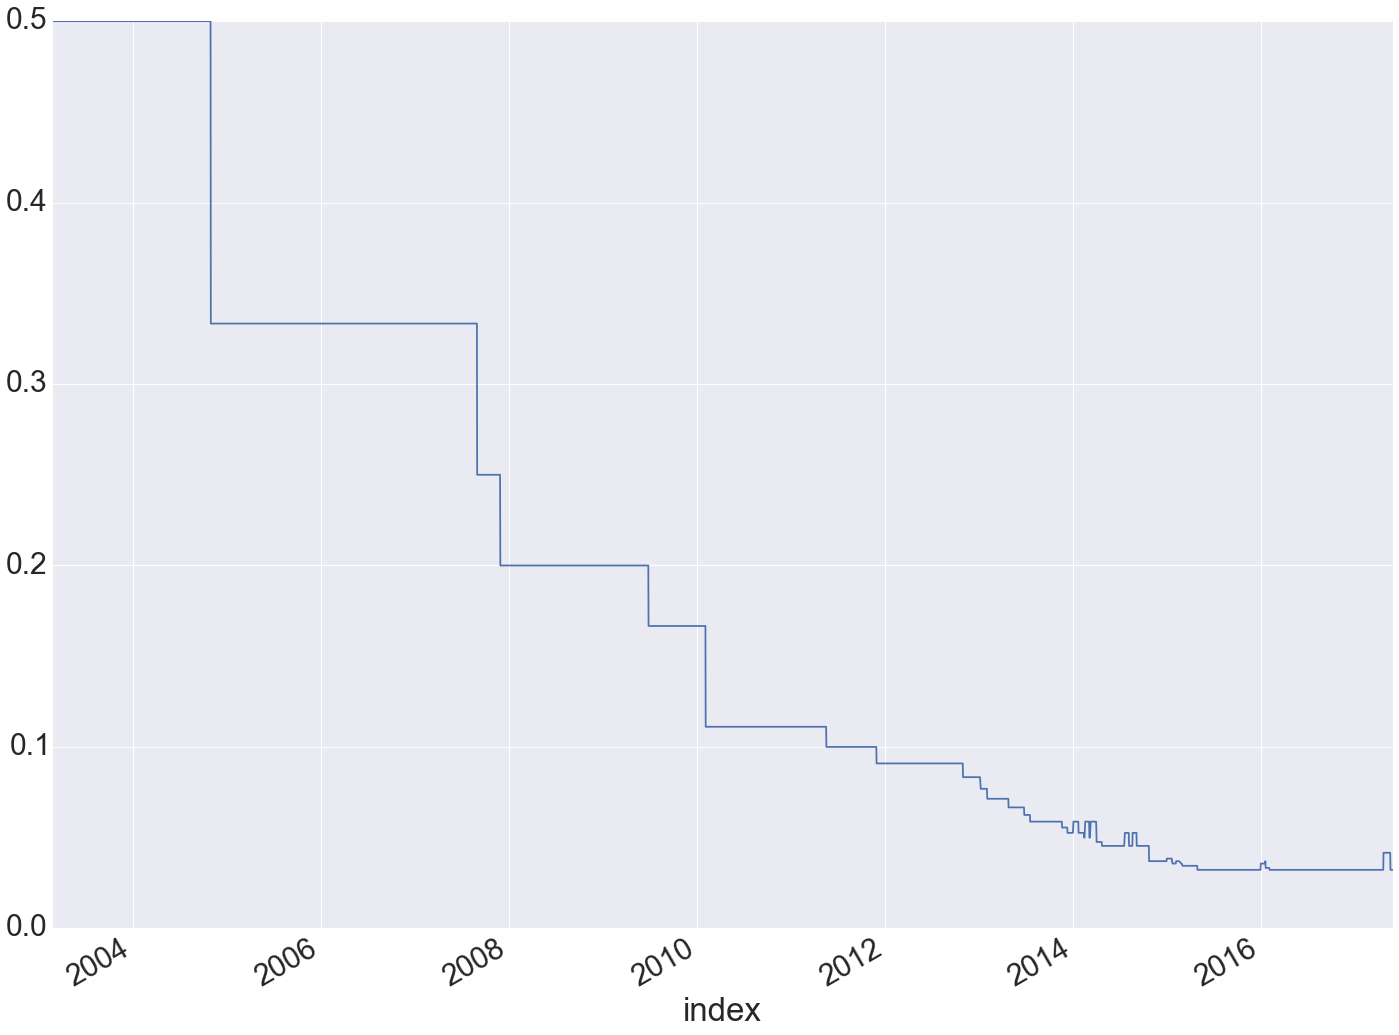

In [18]:
(1/pnl.dropna(how='all').count(axis=1)).plot()

# Calculate Notional Position

$$ Position_{m,t} = \frac{signal_{m,t} * scalingFactor_t * FundAUM_t * weight_{m,t} }{ContractSize_{m,t} } $$

Breaking out the scaling factor as something seems a bit off:

$$ Position_{m,t} = \frac{signal_{m,t} * \sigma_{target} * FundAUM_t * weight_{m,t} * DiversificationBenefit_t }{\sigma_{t}*ContractSize_{m,t} } $$

If you were just trading one market using risk scaling targetting a certain target
$$Position_{m,t} = \frac{\sigma_{target}*FundAUM_t  }{\sigma_t*contractSize_t} $$


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=50,adjust=True,com=50).std(bias=False)
  app.launch_new_instance()


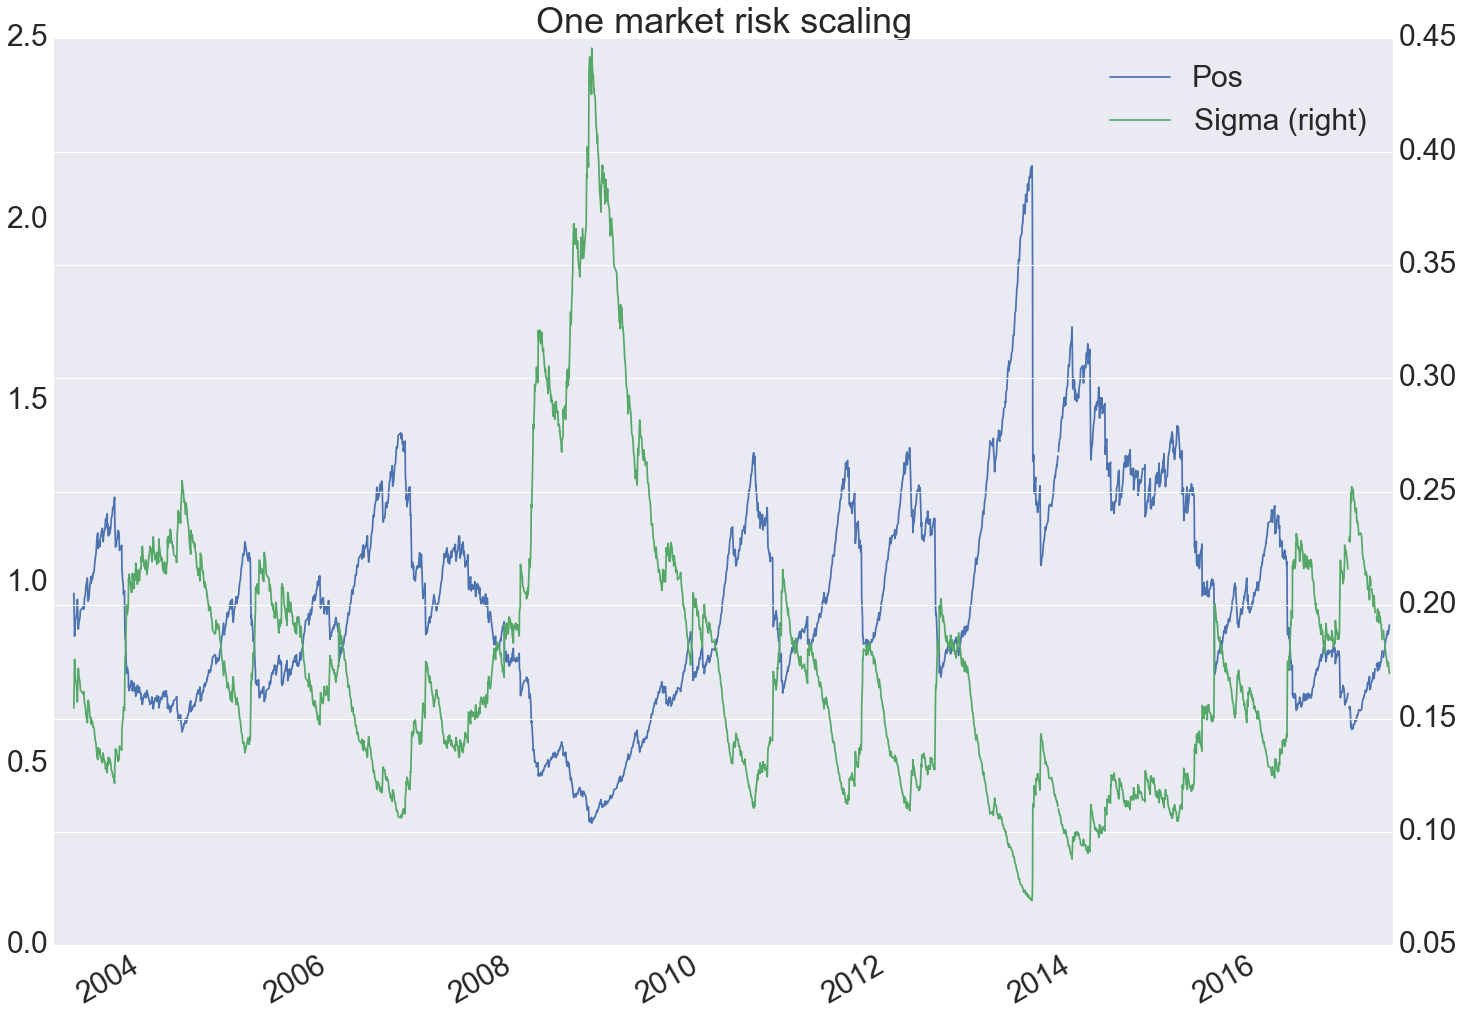

In [19]:
data=df[mkts]
FundAUM=1e6
sig=pd.ewmstd(data.A,50,min_periods=50).dropna()*16
p=(.15*FundAUM)/(sig*curr_px.A)
temp =pd.DataFrame()
temp['Pos']=((p*curr_px.A)/FundAUM)
temp['Sigma']=sig
temp.plot(secondary_y='Sigma',title='One market risk scaling')

In [20]:
FundAUM = 1e6
w=(1/pnl.dropna(how='all').count(axis=1))

In [46]:
def tsmom_daily_signal(data,signal_lookback,vol_lookback=20):
    vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
    signal=pd.rolling_mean(data,signal_lookback)
    signal = signal /abs(signal)
    return (signal / (vol))

In [21]:
data=df[mkts]
vol_lookback=20
signal_lookback=250

mul=get_contract_multipliers()[data.columns]
vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
signal=pd.rolling_mean(data,signal_lookback)
signal = signal /abs(signal)
signal=(signal / (vol))


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,center=False).mean()


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,center=False).mean()
  app.launch_new_instance()


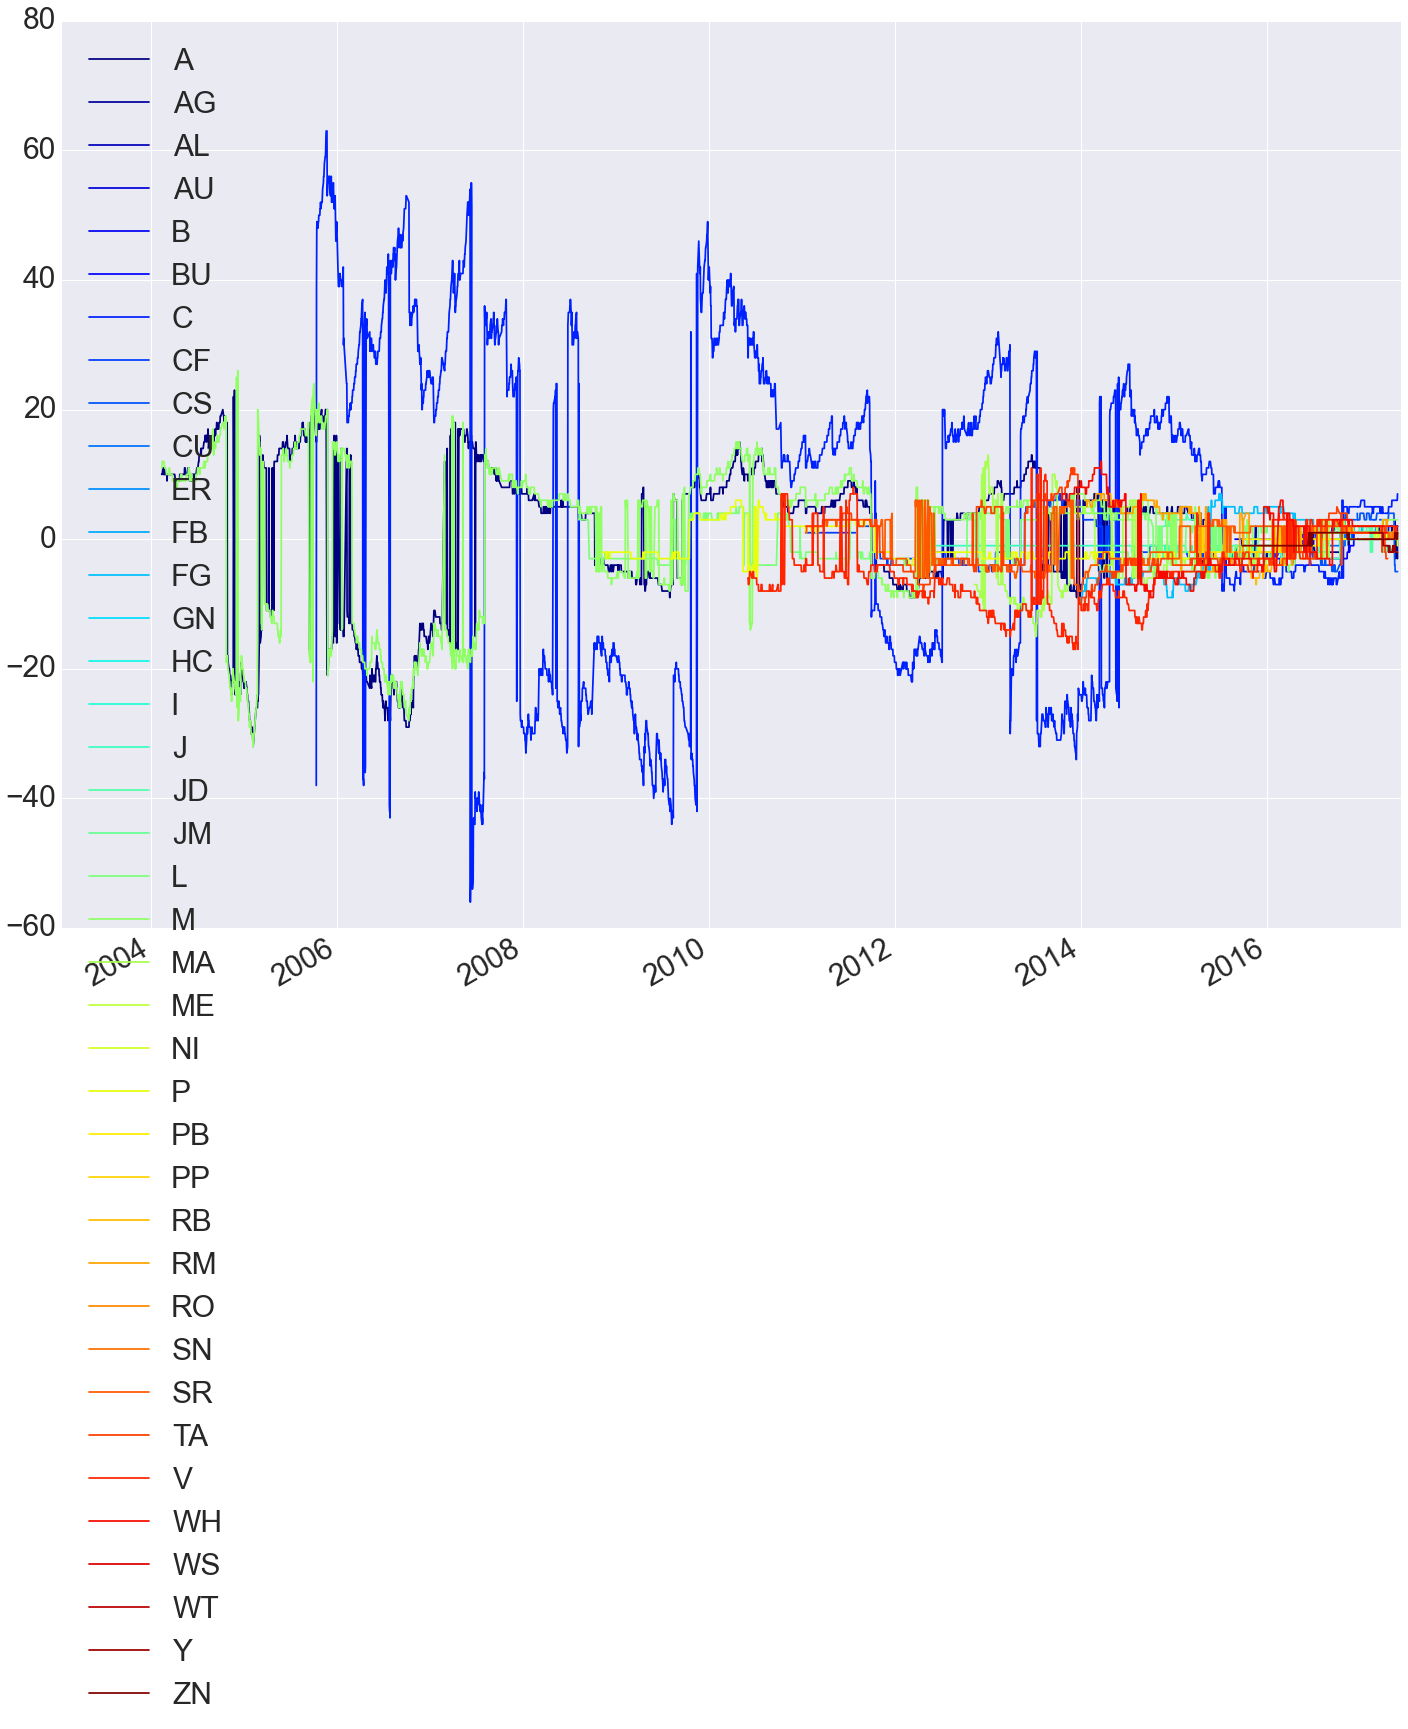

In [70]:
s=tsmom_daily_signal(df,250)
calc_position(s,FundAUM,scaling_factor).plot(colormap='jet')

In [76]:
x=calc_position(s,FundAUM,scaling_factor)

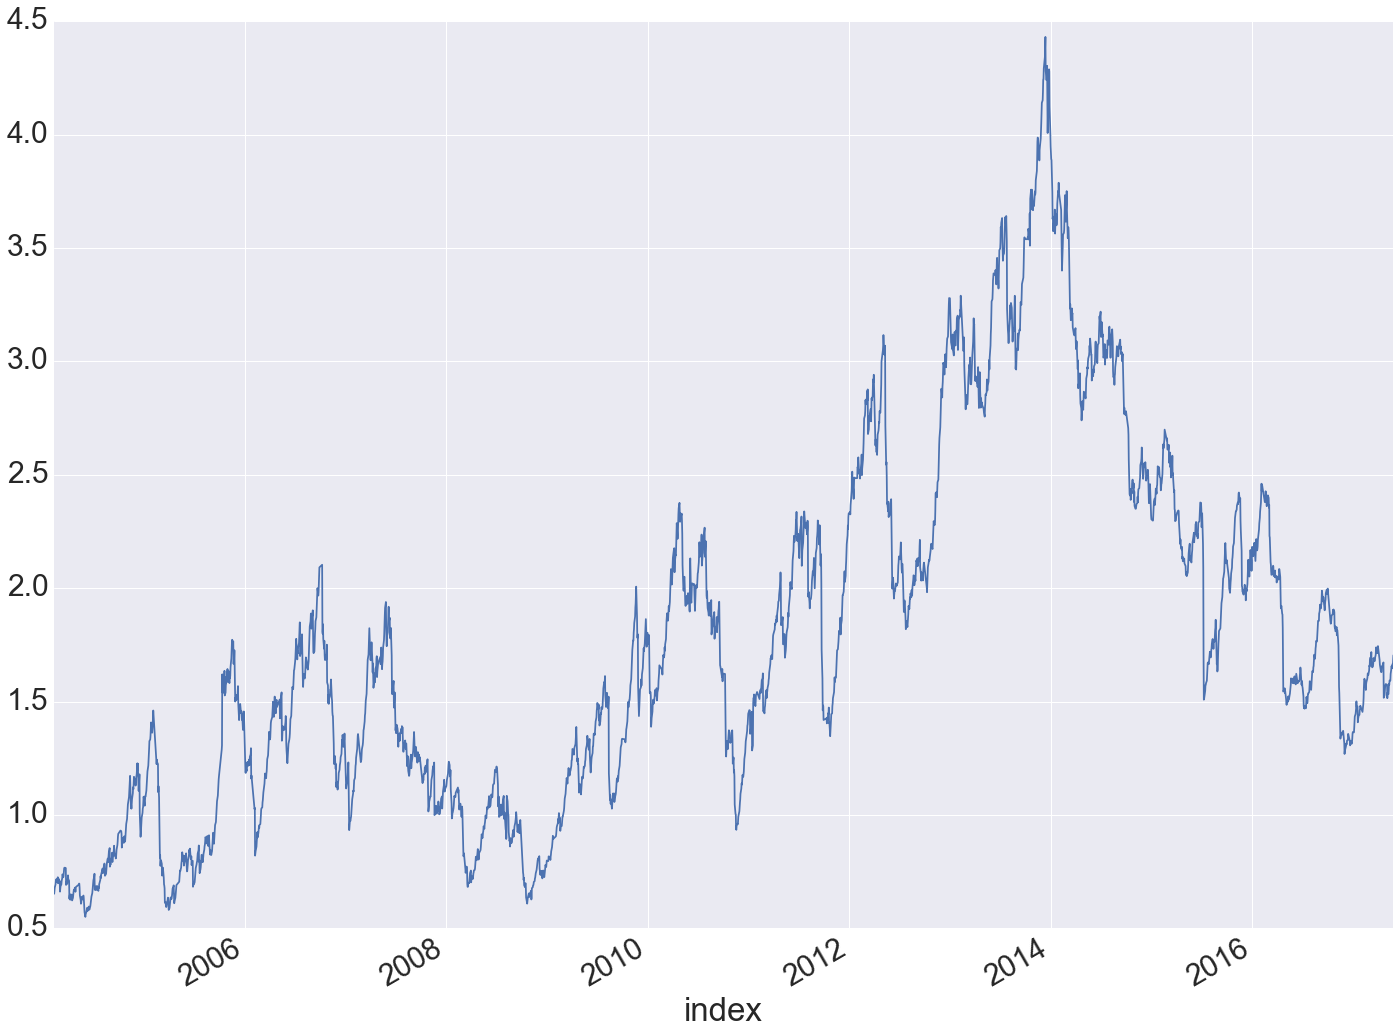

In [72]:
(x.abs()/FundAUM).sum(axis=1).plot()

In [69]:
def calc_position(signal,FundAUM,scaling_factor):
    w=(1/signal.dropna(how='all').count(axis=1))
    dict={}
    for m in signal.columns:
        dict[m]=(signal[m]*FundAUM*w*scaling_factor)/(curr_px[m]*mul[m]).dropna()
    return pd.DataFrame().from_dict(dict).round()

In [22]:
dict={}
for m in signal.columns:
    dict[m]=(signal[m]*FundAUM*w*scaling_factor).dropna()

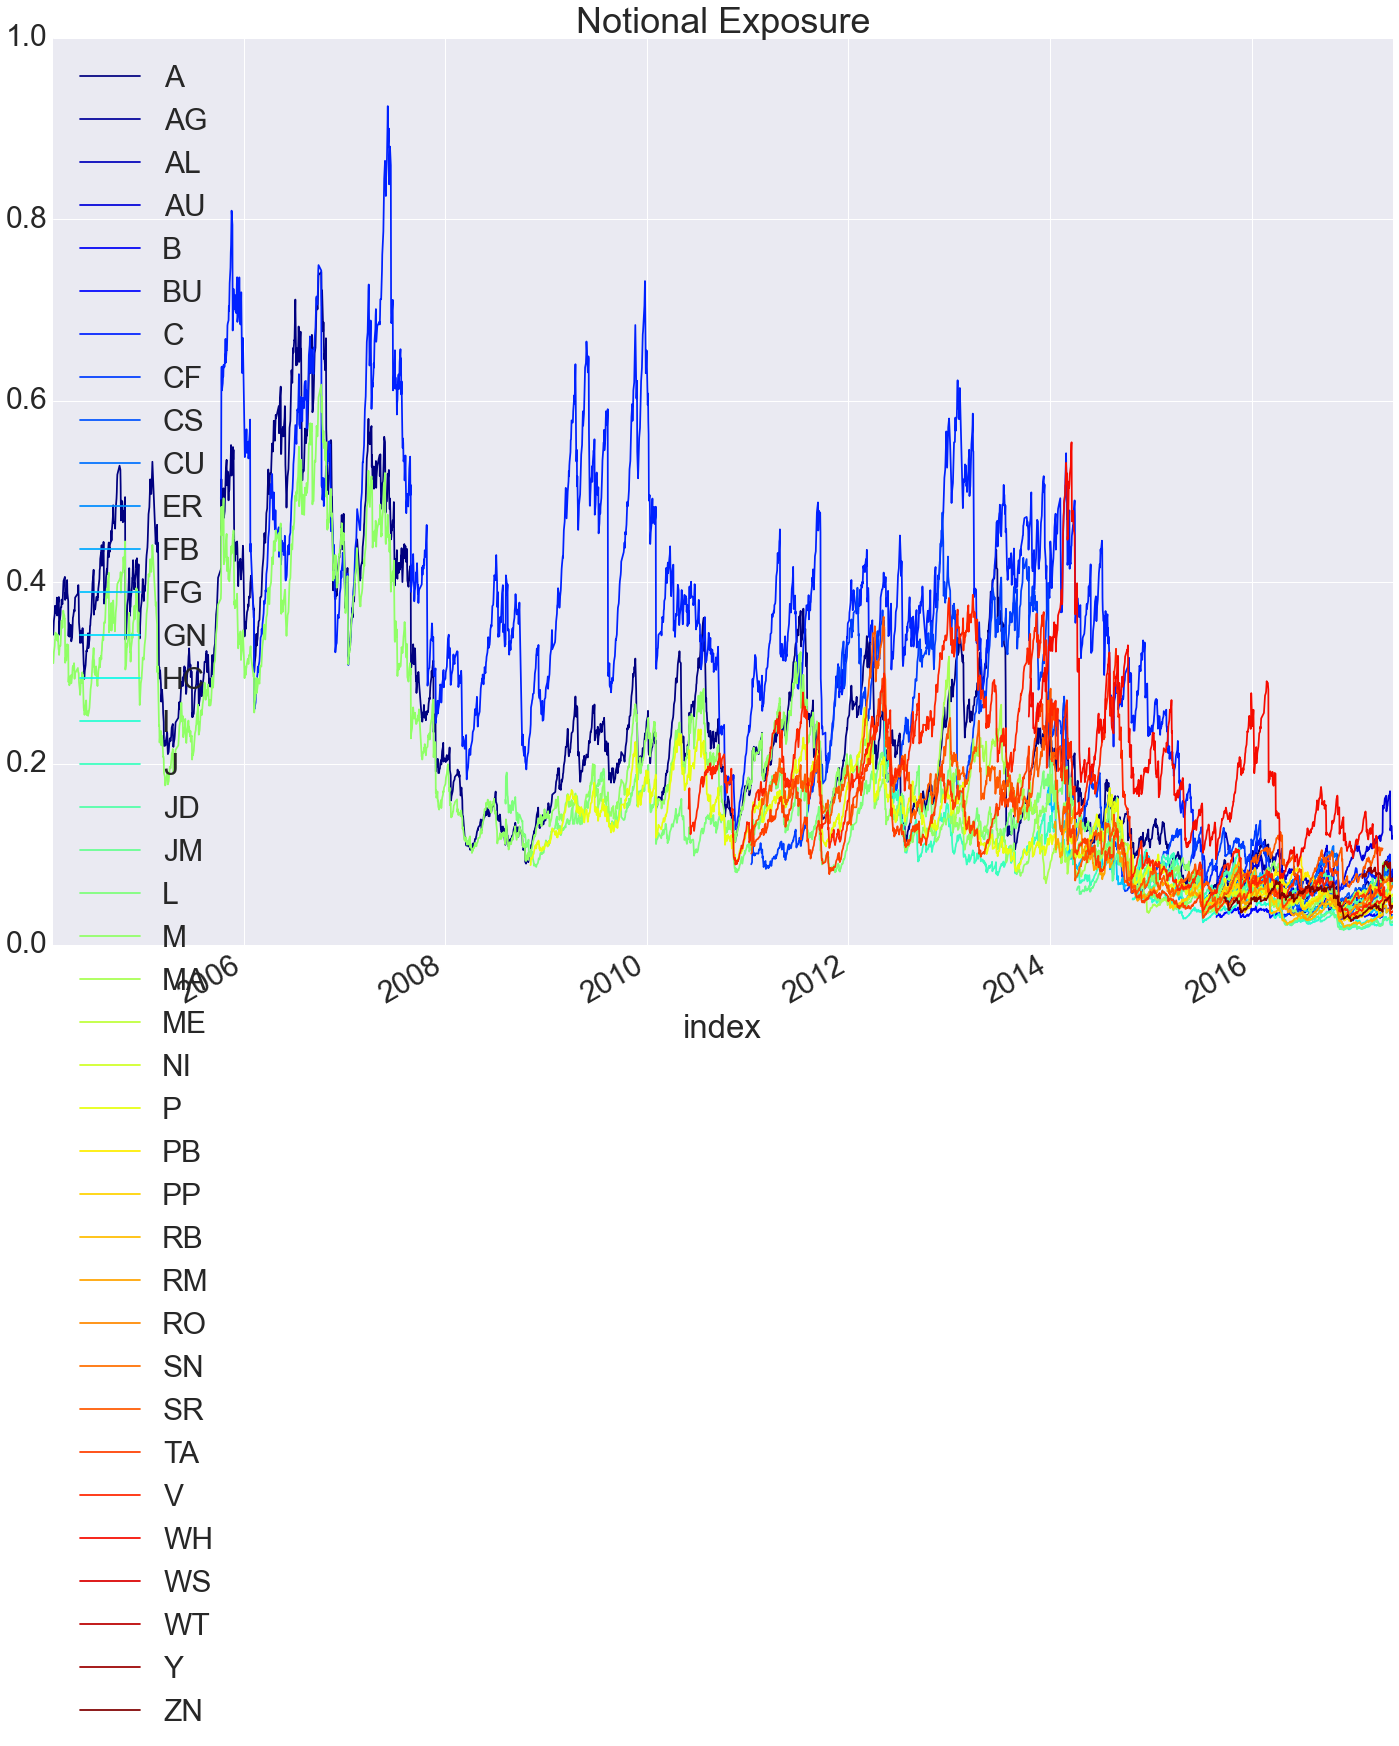

In [23]:
(pd.DataFrame().from_dict(dict).abs()/FundAUM).plot(colormap='jet',title='Notional Exposure')

# Calculate rounded lots

$$ Position_{m,t} =round\left( \frac{signal_{m,t} * \sigma_{target} * FundAUM_t * weight_{m,t} * DiversificationBenefit_t }{\sigma_{t}*ContractSize_{m,t} }\right) $$

In [24]:
dict={}
for m in signal.columns:
    dict[m]=(signal[m]*FundAUM*w*scaling_factor)/(curr_px[m]*mul[m]).dropna()
    

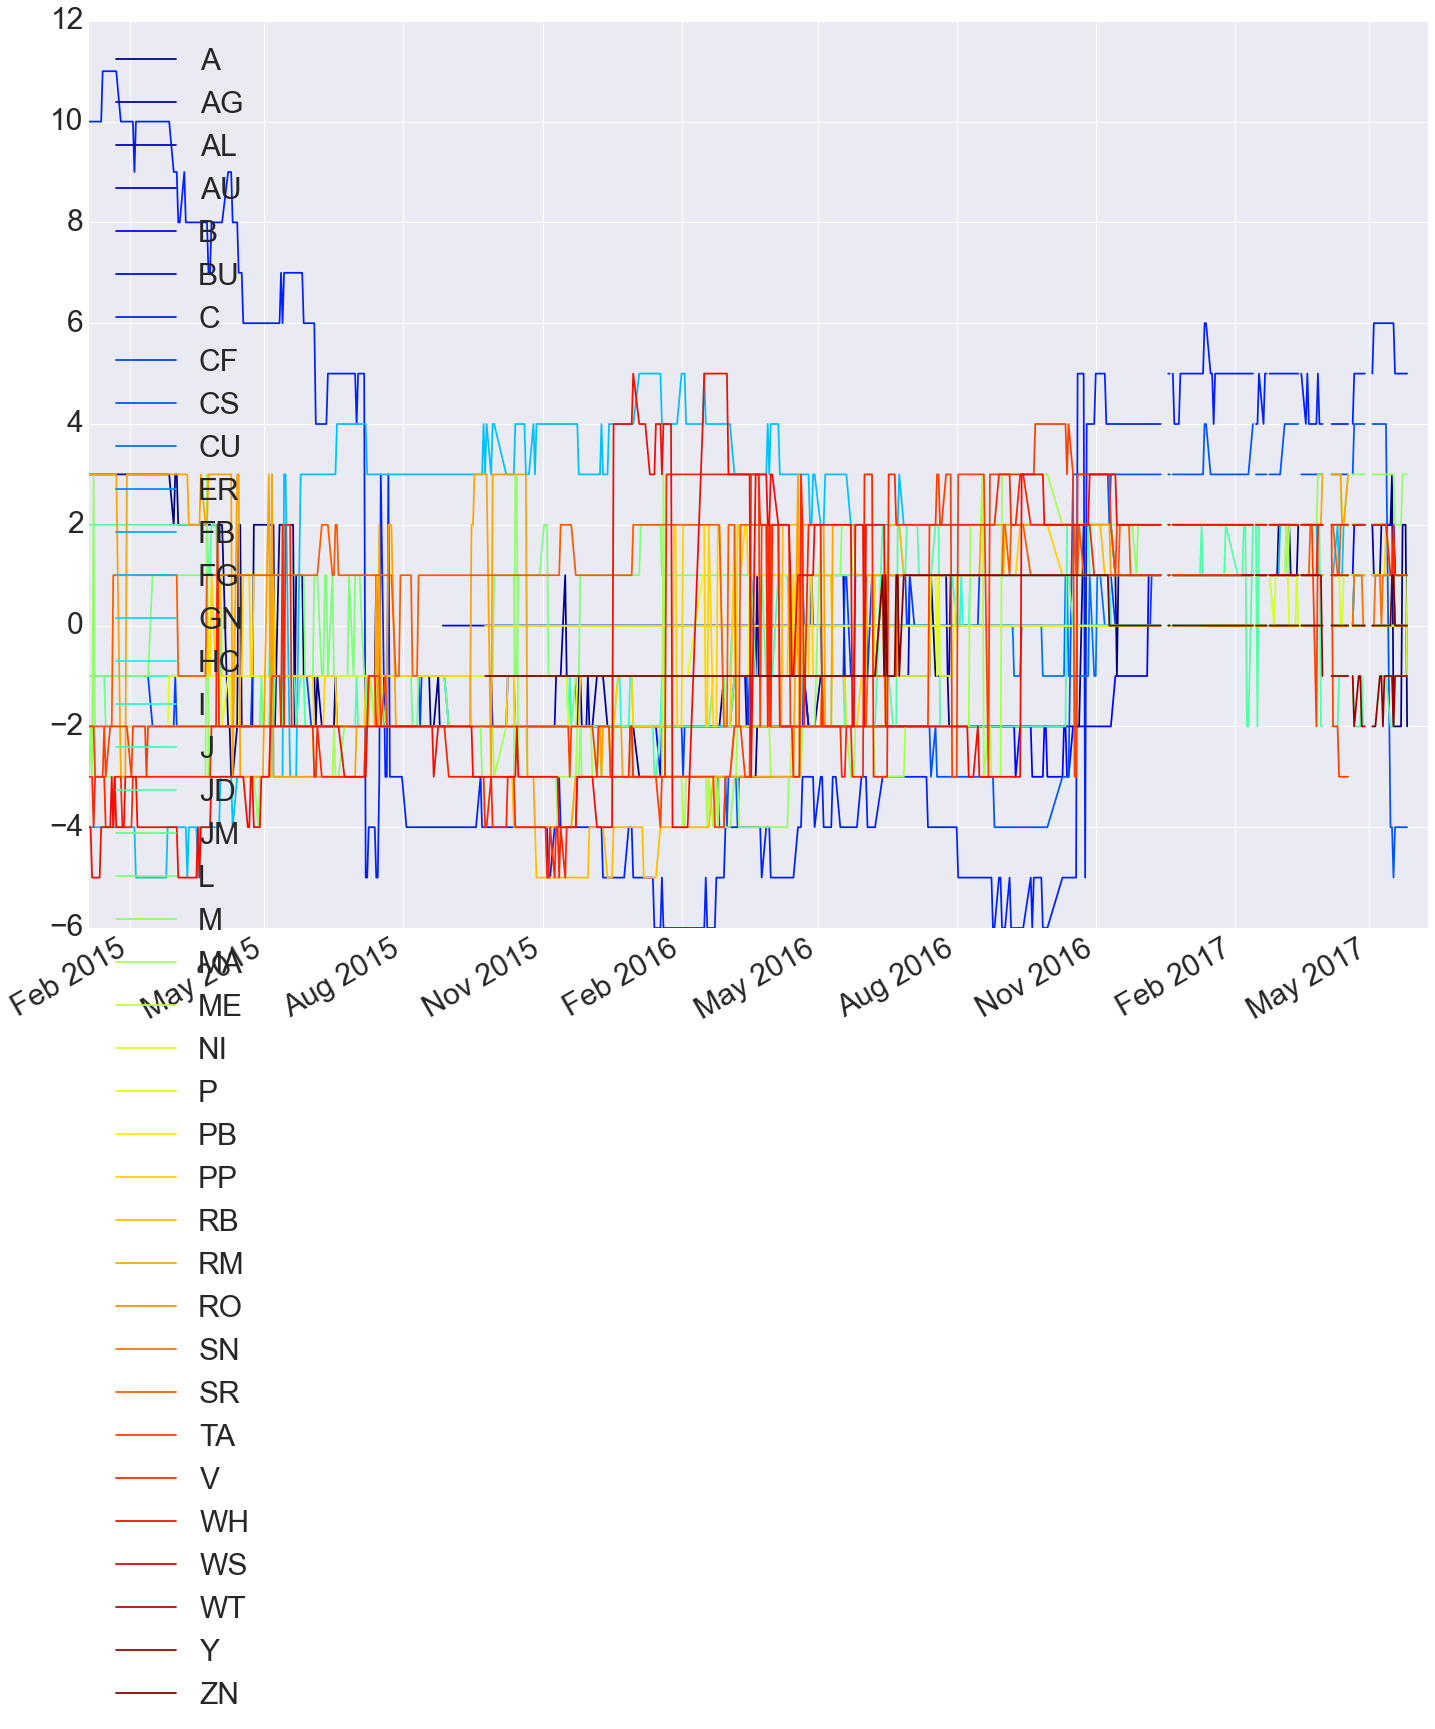

In [25]:
pd.DataFrame().from_dict(dict).round()['2015':].plot(colormap='jet')

In [33]:
rounded_position=pd.DataFrame().from_dict(dict).round()

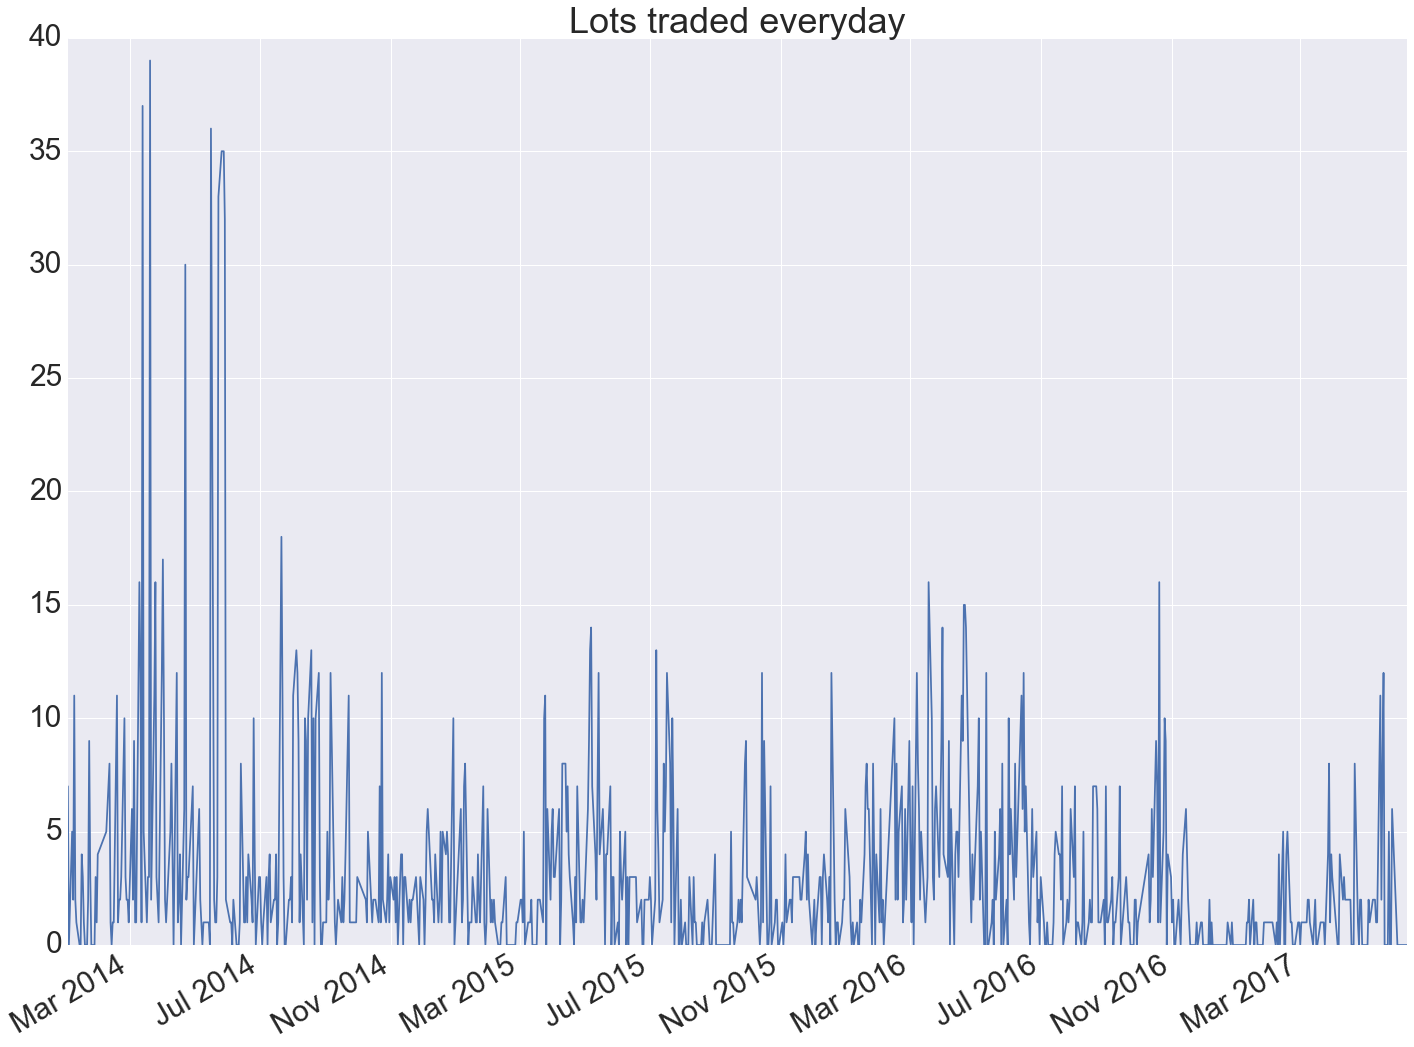

In [45]:
rounded_position.diff().abs().sum(axis=1)['2014':].plot(title='Lots traded everyday')

# Position lots calculate pnl
$$ Position_{m,t} =round\left( \frac{signal_{m,t} * \sigma_{target} * FundAUM_t * weight_{m,t} * DiversificationBenefit_t }{\sigma_{t}*ContractSize_{m,t} }\right) $$

$$PNL=Position_{m,t}*Price_{m,t}*Price_{m,t}*ContactSize_{m,t}$$


In [ ]:
def calc_pnl_position(position,data,curr_px,fee=0.0005):
    mul=get_contract_multipliers()[data.columns]
    return (x*data*mul*curr_px)-cost_model_position(position,curr_px,mul,fee)

In [91]:
((x*data*mul*curr_px).sum(axis=1)/FundAUM)['2005':].std()

0.008692315407206204

In [90]:
calc_Sharpe(((x*data*mul*curr_px).sum(axis=1)/FundAUM)['2005':],250)

1.7435395320805738

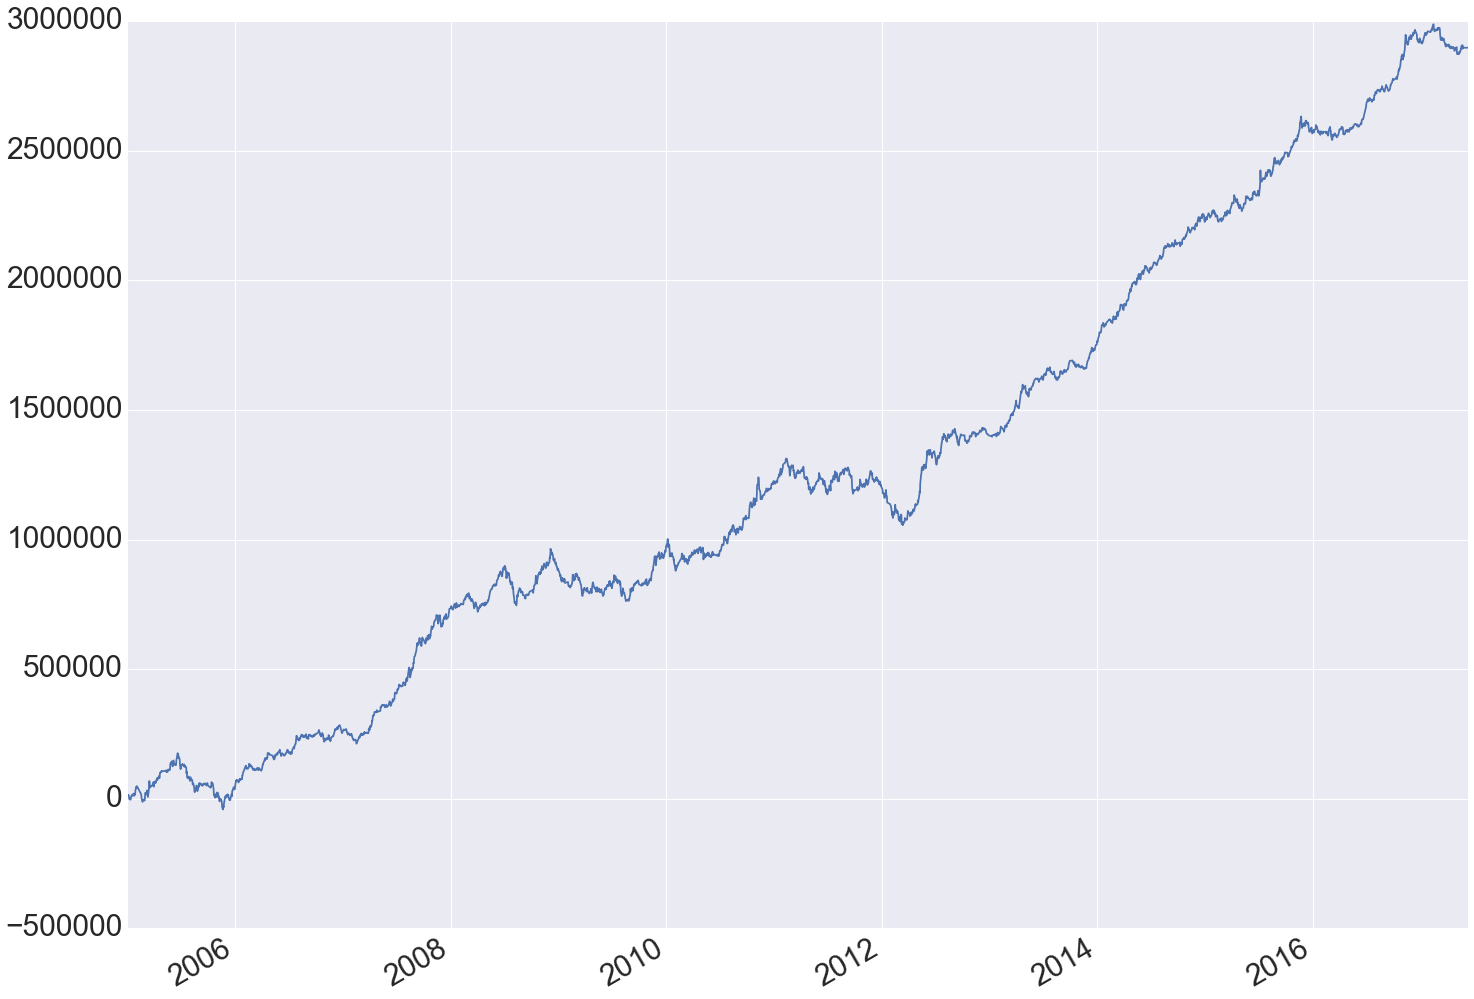

In [87]:
(x*data*mul*curr_px).sum(axis=1)['2005':].cumsum().plot()

# Cost model

In [102]:
def calc_pnl_position_wc(position,data,curr_px,fee=0.0005):
    mul=get_contract_multipliers()[data.columns]
    return (position*data*mul*curr_px)-cost_model_position(position,curr_px,mul,fee)

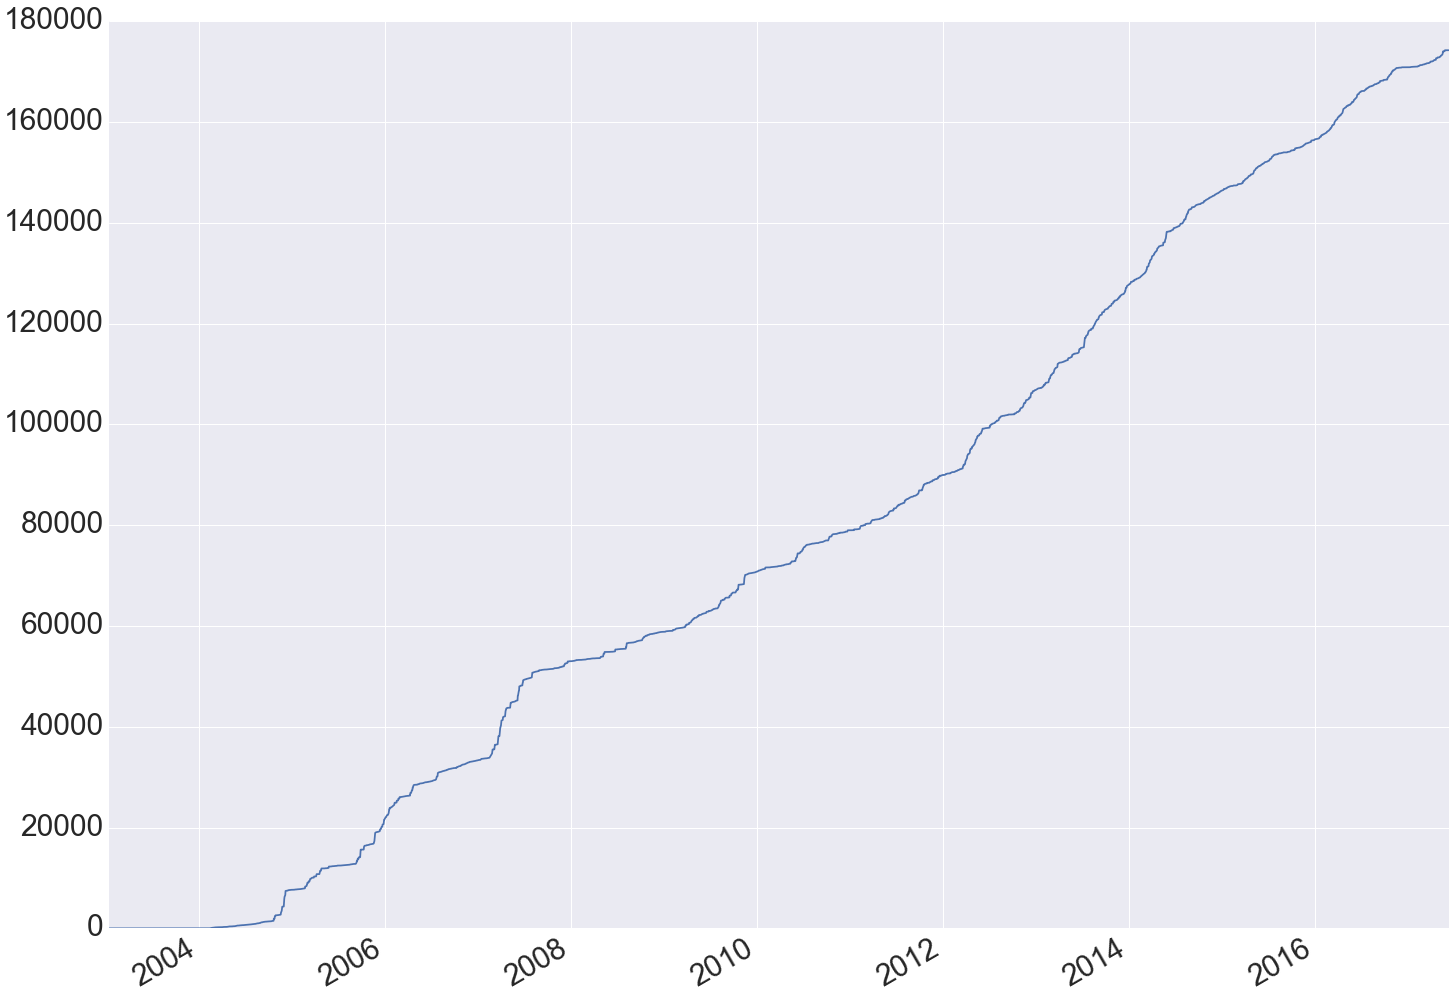

In [99]:
fee=0.0005
(rounded_position.diff().abs()*curr_px*mul*fee).sum(axis=1).cumsum().plot()

# Checking if it makes sense

* Vol on each market is actually high

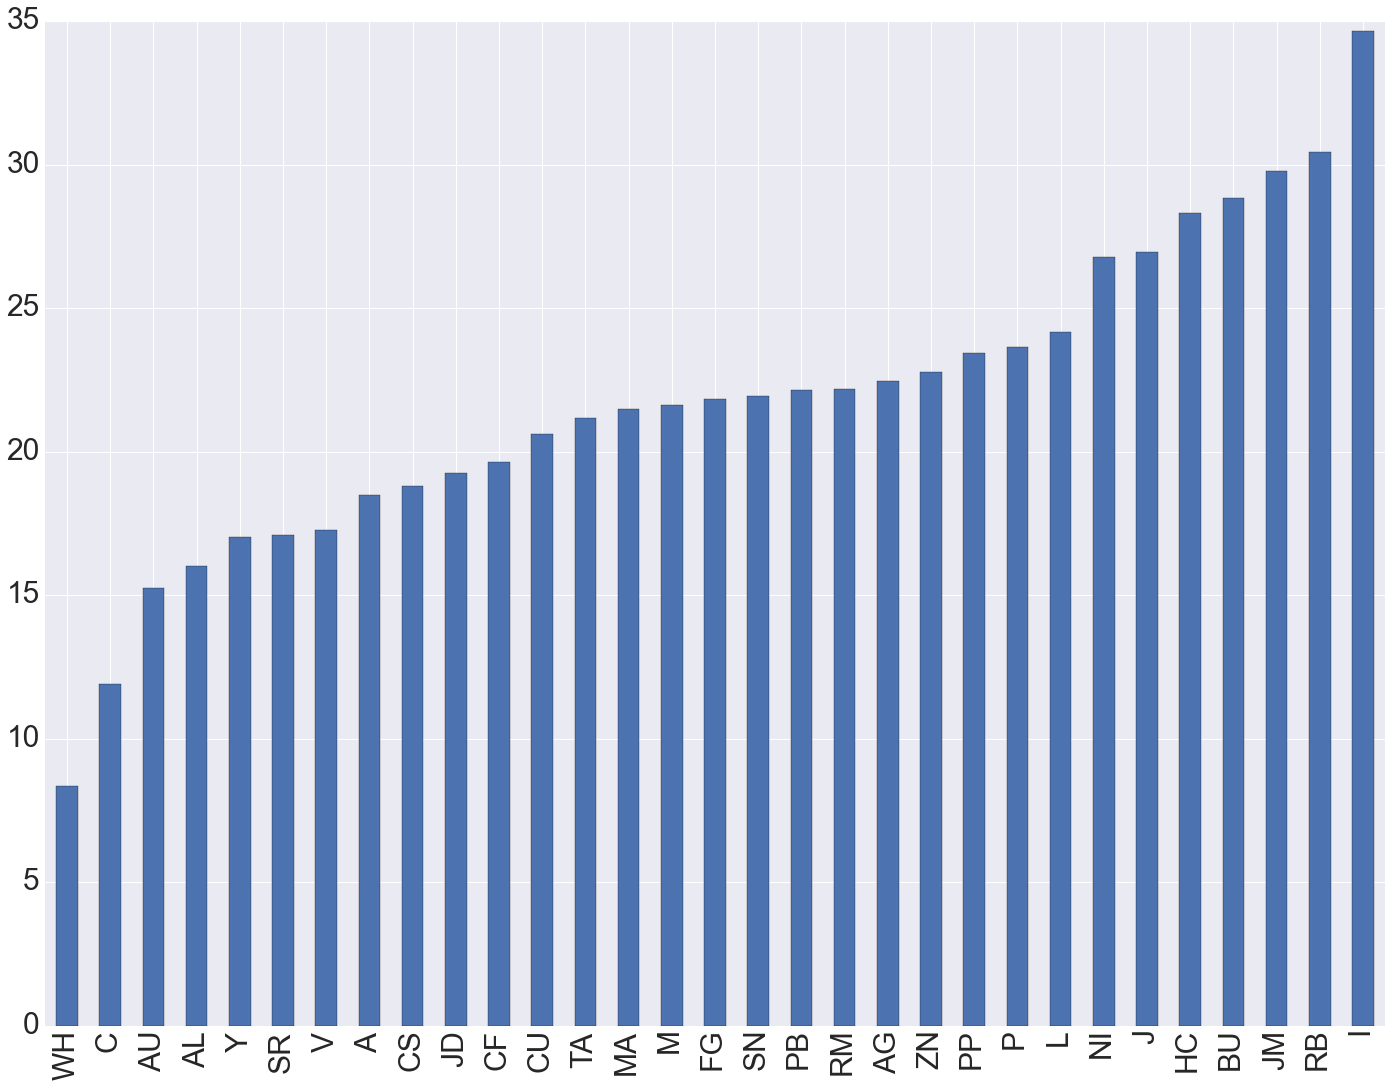

In [30]:
(data.std()*1600).dropna().sort_values().plot(kind='bar')

# Putting it all together
* First calculate scaling factor based on old method
* calculate positions and position level pnl

In [101]:
mkts=get_market_list()
pos=tsmom_daily(df[mkts],250)
pnl=calc_pnl_wc(pos,df[mkts])
scaling_factor=calc_scaling_factor(pnl)

In [106]:
FundAUM=1e6
curr_px=get_most_liquid_price(mkts)

s=tsmom_daily_signal(data,250)
lots=calc_position(s,FundAUM,scaling_factor)
PNL = calc_pnl_position_wc(lots,data,curr_px)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,center=False).mean()
  app.launch_new_instance()


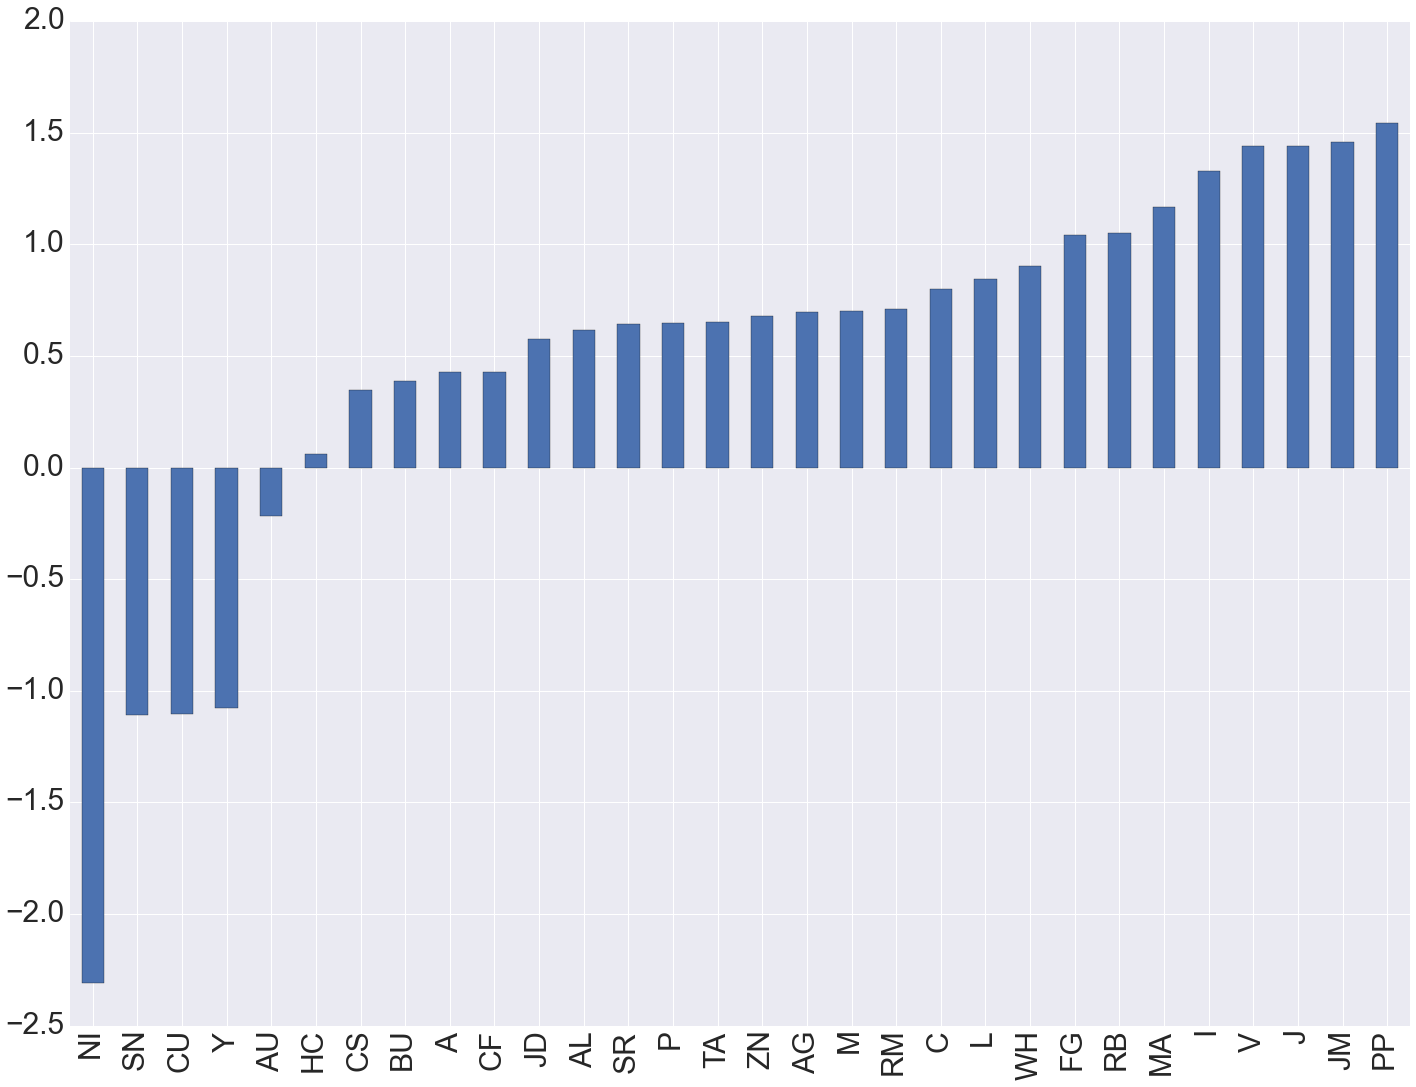

In [108]:
calc_Sharpe(PNL/FundAUM,250).dropna().sort_values().plot(kind='bar')